In [1]:
# This reads in some scraped data and produces final data to plot,
# as a check on the class findHK()

# This should be used in conjunction with test_scrape_ew_and_errew.py

# Created 2019 Apr 13 by E.S.

In [2]:
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt

In [3]:
# configuration data
config = configparser.ConfigParser() # for parsing values in .init file
config.read("../rrlyrae_metallicity/modules2/config.ini")

['../rrlyrae_metallicity/modules2/config.ini']

In [4]:
stem = ("/Users/nyumbani/Documents/git.repos/rrlyrae_metallicity/"+\
    "rrlyrae_metallicity/tests/test_robospect_output")

In [5]:
# fake EW data (note this is with the fake 'bad' data removed)

scraped_EW_filename = config["data_dirs"]["TEST_DIR_ROBO_OUTPUT"] + config["file_names"]["MCD_LARGE_BAD_REMOVED"]
data = pd.read_csv(scraped_EW_filename)

fake_phases_filename = config["data_dirs"]["TEST_DIR_SRC"] + config["file_names"]["DETACHED_PHASES"]
phases = pd.read_csv(fake_phases_filename)

In [6]:
# get the unique, 'good' spectrum names 

unique_good_empir_spec_names = data["empir_spec_name"].drop_duplicates().dropna().reset_index(drop=True) 

In [7]:
# print

unique_good_empir_spec_names

0           all_good_01
1           all_good_02
2    bad_hbeta_wavel_99
3    fit_center_flag_99
Name: empir_spec_name, dtype: object

In [8]:
# separate the data by absorption line

data_Heps = data.where(data["line_name"] == "Heps").dropna().reset_index(drop=True) 
data_Hdel = data.where(data["line_name"] == "Hdel").dropna().reset_index(drop=True) 
data_Hgam = data.where(data["line_name"] == "Hgam").dropna().reset_index(drop=True) 
data_Hbet = data.where(data["line_name"] == "Hbet").dropna().reset_index(drop=True) 
data_CaIIK = data.where(data["line_name"] == "CaIIK").dropna().reset_index(drop=True) 

In [9]:
data_CaIIK

,Unnamed: 0,#x0,mean,sigma,flux,eta,dmean,dsigma,dflux,deta,...,FWHM_F,EQW,dEQW,chi,flags,group,file_name,synth_spec_name,empir_spec_name,line_name
0,0.0,3933.66,3935.0716,2.1122,-3.4117,0.0,0.0119,0.0092,0.0046,0.0,...,-1.4821,3412.0,4.631,0.2026,0x100000,0.0,all_good_01_004.fits.robolines,all_good_01_004,all_good_01,CaIIK
1,5.0,3933.66,3933.3382,2.7377,-2.5969,0.0,0.0667,0.0507,0.0120,0.0,...,-2.2862,2597.0,12.050,0.3644,0x100000,0.0,all_good_01_066.fits.robolines,all_good_01_066,all_good_01,CaIIK
2,10.0,3933.66,3935.1686,3.5040,-6.4082,0.0,0.1085,0.0732,0.0421,0.0,...,-3.4822,6408.0,42.060,2.1364,0x100000,0.0,all_good_01_102.fits.robolines,all_good_01_102,all_good_01,CaIIK
3,15.0,3933.66,3933.4470,1.8191,-2.1252,0.0,0.0081,0.0059,0.0023,0.0,...,-2.0989,2125.0,2.273,0.2952,0x100000,0.0,all_good_01_107.fits.robolines,all_good_01_107,all_good_01,CaIIK
4,20.0,3933.66,3932.6660,5.2102,-4.9698,0.0,0.7227,0.5136,0.1317,0.0,...,-2.9670,4970.0,131.700,3.6449,0x100000,0.0,all_good_02_004.fits.robolines,all_good_02_004,all_good_02,CaIIK
5,25.0,3933.66,3933.8022,2.3792,-3.7596,0.0,0.0191,0.0137,0.0067,0.0,...,-3.6677,3760.0,6.748,0.3016,0x100000,0.0,all_good_02_014.fits.robolines,all_good_02_014,all_good_02,CaIIK
6,30.0,3933.66,3933.7022,2.7529,-4.9658,0.0,0.0271,0.0189,0.0118,0.0,...,-4.6821,4966.0,11.840,0.7936,0x100000,0.0,all_good_02_044.fits.robolines,all_good_02_044,all_good_02,CaIIK
7,35.0,3933.66,3933.4075,3.1201,-4.8337,0.0,0.0382,0.0261,0.0141,0.0,...,-4.6007,4834.0,14.120,0.7382,0x100000,0.0,all_good_02_058.fits.robolines,all_good_02_058,all_good_02,CaIIK
8,40.0,3933.66,3936.1005,4.0886,-8.0256,0.0,0.2403,0.1737,0.1032,0.0,...,-3.7053,8026.0,103.200,2.5092,0x100000,0.0,all_good_02_104.fits.robolines,all_good_02_104,all_good_02,CaIIK
9,45.0,3933.66,3934.8120,2.5803,-4.1397,0.0,0.0180,0.0130,0.0069,0.0,...,-3.6786,4140.0,6.921,0.7368,0x100000,0.0,bad_hbeta_wavel_99_999.fits.robolines,bad_hbeta_wavel_99_999,bad_hbeta_wavel_99,CaIIK


In [10]:
# fit line to Hgamma (y) vs Hdelta (x)

m, b = np.polyfit(data_Hdel["EQW"], data_Hgam["EQW"], 1)

In [11]:
# initialize the dataframe which will hold the data to plot
# (each row in this dataframe will represent one synthetic spectrum)

KH_synthetic_data = pd.DataFrame()

In [12]:
# make rescaled Hgamma: Hgamma’ = (Hgamma - b)/m
# ... and be sure to associate an empirical spectrum name with each

KH_synthetic_data["rHgam"] = np.divide(np.subtract(data_Hgam["EQW"],b),m)
KH_synthetic_data["empir_spec_name"] = data_Hgam["empir_spec_name"]
KH_synthetic_data["synth_spec_name"] = data_Hgam["synth_spec_name"]

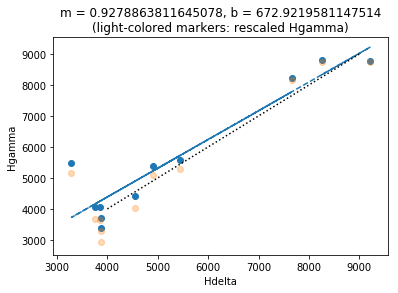

In [13]:
# plot Hgamma vs Hdelta before and after rescaling,
# for all synthetic spectra

plt.scatter(data_Hdel["EQW"], data_Hgam["EQW"])
plt.scatter(data_Hdel["EQW"], KH_synthetic_data["rHgam"], marker="o", alpha=0.3)
plt.plot(data_Hdel["EQW"], np.add(np.multiply(m,data_Hdel["EQW"]),b), linestyle="--")
plt.plot([4000,9000], [4000,9000], linestyle=":", color="k") # 1-to-1
plt.xlabel("Hdelta")
plt.ylabel("Hgamma")
plt.title("m = " + str(m) + ", b = " + str(b) + "\n(light-colored markers: rescaled Hgamma)")
plt.show()

In [15]:
# plug in the CaIIK data

# initialize
KH_synthetic_data["CaIIK"] = np.nan*KH_synthetic_data["rHgam"]
KH_synthetic_data["Hdel"] = np.nan*KH_synthetic_data["rHgam"]
KH_synthetic_data["Hgam"] = np.nan*KH_synthetic_data["rHgam"]

# loop over synthetic spectra names and pick out the data for the other lines
for p in range(0,len(KH_synthetic_data["CaIIK"])):
    caiik_here = np.copy(data_CaIIK["EQW"].where(
        data_CaIIK["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)
    Hdel_here = np.copy(data_Hdel["EQW"].where(
        data_Hdel["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)
    Hgam_here = np.copy(data_Hgam["EQW"].where(
        data_Hgam["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)
    KH_synthetic_data.loc[p, ["CaIIK"]] = caiik_here # note the .loc syntax here to avoid operating on a copy
    KH_synthetic_data.loc[p, ["Hdel"]] = Hdel_here 
    KH_synthetic_data.loc[p, ["Hgam"]] = Hgam_here 

In [16]:
# calculate a net Balmer line: average between Hdel and re-scaled Hgam

KH_synthetic_data["Balmer"] = np.mean([KH_synthetic_data["rHgam"].values,KH_synthetic_data["Hdel"].values], axis=0)

In [17]:
phases

,Unnamed: 0,Spectrum,EW_K,eEW_K,EW_D,eEW_D,EW_G,eEW_G,EW_B,eEW_B,Have,eHave,FeH,eFeH,phase,period,type,eckhart_FeH_fit
0,0,all_good_01,9.771,0.251,4.636,0.209,4.574,0.249,5.237,0.555,4.658,0.154,-0.31,0.15,0.707,0.425566,RRab,-0.351248
1,1,all_good_02,9.007,0.110,4.904,0.123,4.636,0.119,5.225,0.244,4.816,0.081,-0.31,0.15,0.736,0.425566,RRab,-0.539792
2,2,bad_hbeta_wavel_99,8.094,0.260,4.398,0.340,4.745,0.607,5.766,0.666,4.693,0.271,-0.31,0.15,0.901,0.425566,RRab,-0.825136
3,3,fit_center_flag_99,4.474,0.094,12.772,0.337,12.357,0.271,11.900,0.433,12.401,0.190,-0.31,0.15,0.000,0.425566,RRab,-0.271608


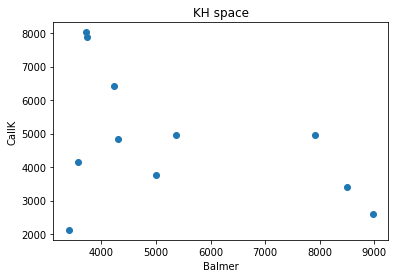

In [18]:
# plot KH space, plotting all synthetic spectra separately
# (note this will not involve error bars)

plt.clf()
plt.scatter(KH_synthetic_data["Balmer"], KH_synthetic_data["CaIIK"])
plt.xlabel("Balmer")
plt.ylabel("CaIIK")
plt.title("KH space")
plt.show()

In [21]:
# calculate median points, with error bars, for each empirical spectrum

# initialize arrays
empir_spec_name_array = []
Balmer_array = []
CaIIK_array = []
err_Balmer_array = []
err_CaIIK_array = []
phase_array = []

# loop over each empirical spectrum
for empir_num in range(0,len(unique_good_empir_spec_names)):
    
    data_for_this_empir_spectrum = KH_synthetic_data.where(
        KH_synthetic_data["empir_spec_name"] == np.array(unique_good_empir_spec_names)[empir_num]
    )
    
    empir_spec_name_array = np.concatenate((empir_spec_name_array, [np.array(unique_good_empir_spec_names)[empir_num]]))
    Balmer_array = np.concatenate((Balmer_array,[np.nanmedian(data_for_this_empir_spectrum["Balmer"])]))
    CaIIK_array = np.concatenate((CaIIK_array,[np.nanmedian(data_for_this_empir_spectrum["CaIIK"])]))
    err_Balmer_array = np.concatenate((err_Balmer_array,[np.nanstd(data_for_this_empir_spectrum["Balmer"])]))
    err_CaIIK_array = np.concatenate((err_CaIIK_array,[np.nanstd(data_for_this_empir_spectrum["CaIIK"])]))
    
    phase_here = phases["phase"].where(
        phases["Spectrum"] == np.array(unique_good_empir_spec_names)[empir_num]).dropna().values
    phase_array = np.concatenate((phase_array,phase_here))
    
# cobble into a single dataframe ('reduced' because each row corresponds to an empirical spectrum)
KH_reduced_data = pd.DataFrame({"Balmer":Balmer_array, 
                                "CaIIK":CaIIK_array, 
                                "err_Balmer":err_Balmer_array, 
                                "err_CaIIK":err_CaIIK_array,
                                "empir_spec_name": empir_spec_name_array,
                                "phase": phase_array})

10
[0.707]
10
[0.736]
10
[0.901]
10
[0.]


In [ ]:
## NEXT: SEPARATE INTO GOOD AND BAD PHASE REGIONS; MAKE SYNTHETIC SPECTRA COME FROM SAME TRUE EMPIRICAL SPECTRUM; PLOT

In [22]:
KH_reduced_data

,Balmer,CaIIK,empir_spec_name,err_Balmer,err_CaIIK,phase
0,6365.571699,3004.5,all_good_01,2485.140663,1665.593063,0.707
1,4999.340325,4966.0,all_good_02,1443.394243,1431.059803,0.736
2,3576.329088,4140.0,bad_hbeta_wavel_99,0.000000,0.000000,0.901
3,3744.574865,7896.0,fit_center_flag_99,0.000000,0.000000,0.000


In [99]:
caiik_here = np.copy(data_CaIIK["EQW"].where(
        data_CaIIK["synth_spec_name"] == KH_synthetic_data["synth_spec_name"].loc[p]).dropna().values)

,Balmer,CaIIK,empir_spec_name,err_Balmer,err_CaIIK
0,6365.571699,3004.5,all_good_01,2485.140663,1665.593063
1,4999.340325,4966.0,all_good_02,1443.394243,1431.059803
2,3576.329088,4140.0,bad_hbeta_wavel_99,0.000000,0.000000
3,3744.574865,7896.0,fit_center_flag_99,0.000000,0.000000


In [100]:
# read in fake phases
## ## (need to change it so that phases are attached from the beginning)

phases

,Unnamed: 0,Spectrum,EW_K,eEW_K,EW_D,eEW_D,EW_G,eEW_G,EW_B,eEW_B,Have,eHave,FeH,eFeH,phase,period,type,eckhart_FeH_fit
0,0,all_good_01,9.771,0.251,4.636,0.209,4.574,0.249,5.237,0.555,4.658,0.154,-0.31,0.15,0.707,0.425566,RRab,-0.351248
1,1,all_good_02,9.007,0.110,4.904,0.123,4.636,0.119,5.225,0.244,4.816,0.081,-0.31,0.15,0.736,0.425566,RRab,-0.539792
2,2,bad_hbeta_wavel_99,8.094,0.260,4.398,0.340,4.745,0.607,5.766,0.666,4.693,0.271,-0.31,0.15,0.901,0.425566,RRab,-0.825136
3,3,fit_center_flag_99,4.474,0.094,12.772,0.337,12.357,0.271,11.900,0.433,12.401,0.190,-0.31,0.15,0.000,0.425566,RRab,-0.271608
